# Teacher-Student learning

In [85]:
import os
import numpy as np
from tqdm import tqdm #tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib
from sklearn import svm
from scipy.integrate import solve_ivp
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
import warnings
import torch
import matplotlib
from multiprocessing import Pool
%load_ext autoreload
%autoreload 2

#choose which GPU to run
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device='cpu'#'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import seaborn as sns

plt.style.use("default")
rc = {"figure.figsize": (3.2, 2.4), "figure.dpi": 200, "figure.constrained_layout.use": True, "axes.grid": True,
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.5, "grid.linewidth": 0.5,
      "xtick.major.width": 0.5, "ytick.major.width": 0.5, "xtick.major.size": 2.5, "ytick.major.size": 2.5,
      "axes.labelsize": "small", "axes.titlesize": "small", "xtick.labelsize": "small", "ytick.labelsize": "small",
      "axes.titlepad": 2, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1, "patch.linewidth": 0}
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
sns.set_theme(style="ticks", context="paper", palette=sns.color_palette("tab10"), rc=rc)

In [17]:

class Model(torch.nn.Module):

    def __init__(self, n1, n2, n3):
        super(Model, self).__init__()

        self.linear1 = torch.nn.Linear(n1, n2, bias=False)
        self.activation = torch.nn.GELU()
        self.linear2 = torch.nn.Linear(n2, n3, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [19]:
#Data generation
#reproducibility
N, n, m, d = 8,1,1,1
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
X=torch.randn(N,n).to(device)
X_test=torch.randn(N,n).to(device)
y=torch.randn(N,m).to(device)
y_test=torch.randn(N,m).to(device)

In [49]:
Ltrain_list = []
Ltest_list = []
model_list_list=[]

#learning rate and training duration
eta, steps = 0.1, 10001

#outer loop over n_avg
for tt in tqdm(range(8)):
    Ltrain = []
    models_list=[]
    Ltest = []
    n_batch=N
    
    #inner loop over [different noise scale, hidden size, ...]
    for sigma in (0.0, 0.1, 0.2, 0.4, 0.8):
        n_hidden=2  #hidden dimension
        
        np.random.seed(tt)
        torch.manual_seed(tt)
        
        model=Model(n,n_hidden,m).to(device)
        model.linear1.weight.data=torch.Tensor([[1.0],[0.6]]).to(device)
        model.linear2.weight.data=torch.Tensor([[-0.6,-0.4]]).to(device)
        model.to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.9)
        
        ltrain = []
        ltest = []
        model_list=[]

        for i in range(steps):
            
            if i%1==0:
                ttt=np.array([p.detach().cpu().numpy().copy().ravel() for p in model.state_dict().values()])
                model_list.append(ttt)

            optimizer.zero_grad()
            loss_train=((model(X)-y-sigma * torch.randn(N,m).to(device)/np.sqrt(m))**2).sum()*0.5/n_batch
            if loss_train.item()>10**10:
                print('Nan')
            ltrain.append(loss_train.item())
            loss_train.backward()
            optimizer.step()
            if i%1000==0:
                loss_train=((model(X)-y)**2).sum()*0.5/n_batch
                test_loss=((model(X_test)-y_test)**2).sum()*0.5/n_batch
                ltest.append(test_loss.item())
                #print(loss_train,test_loss)

        Ltrain.append(ltrain)
        Ltest.append(ltest)
        models_list.append(model_list)

    Ltrain_list.append(Ltrain)
    Ltest_list.append(Ltest)
    model_list_list.append(models_list)
model_list_list_sigma=model_list_list

100%|██████████| 8/8 [03:31<00:00, 26.38s/it]


In [39]:
Ltrain_list = []
Ltest_list = []
model_list_list=[]

#learning rate and training duration
eta, steps = 0.1, 10001

#outer loop over n_avg
for tt in tqdm(range(8)):
    Ltrain = []
    models_list=[]
    Ltest = []
    n_batch=N
    
    #inner loop over [different noise scale, hidden size, ...]
    for eta in (0.1,0.2,0.3,0.4,0.5):
        sigma=0.1  #label noise
        n_hidden=2  #hidden dimension
        
        np.random.seed(tt)
        torch.manual_seed(tt)
        
        model=Model(n,n_hidden,m).to(device)
        model.linear1.weight.data=torch.Tensor([[1.0],[0.6]]).to(device)
        model.linear2.weight.data=torch.Tensor([[-0.6,-0.4]]).to(device)
        model.to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.9)
        
        ltrain = []
        ltest = []
        model_list=[]

        for i in range(steps):
            
            if i%1==0:
                ttt=np.array([p.detach().cpu().numpy().copy().ravel() for p in model.state_dict().values()])
                model_list.append(ttt)
                #print(ttt)

            optimizer.zero_grad()
            loss_train=((model(X)-y-sigma * torch.randn(N,m).to(device)/np.sqrt(m))**2).sum()*0.5/n_batch#+0.5*0.01*(model.linear1.weight**2).sum()+0.5*0.01*(model.linear2.weight**2).sum()
            if loss_train.item()>10**10:
                print('Nan')
            ltrain.append(loss_train.item())
            loss_train.backward()
            optimizer.step()
            if i%1000==0:
                loss_train=((model(X)-y)**2).sum()*0.5/n_batch
                test_loss=((model(X_test)-y_test)**2).sum()*0.5/n_batch
                ltest.append(test_loss.item())
                #print(loss_train,test_loss)

        Ltrain.append(ltrain)
        Ltest.append(ltest)
        models_list.append(model_list)

    Ltrain_list.append(Ltrain)
    Ltest_list.append(Ltest)
    model_list_list.append(models_list)
model_list_list_lr=model_list_list

100%|██████████| 8/8 [03:31<00:00, 26.43s/it]


In [61]:

n_batch=N

#inner loop over [different noise scale, hidden size, ...]
eta=0.1
sigma=0.1  #label noise
n_hidden=2  #hidden dimension
tt=0

np.random.seed(tt)
torch.manual_seed(tt)

model=Model(n,n_hidden,m).to(device)
model.linear1.weight.data=torch.Tensor([[1.0],[0.6]]).to(device)
model.linear2.weight.data=torch.Tensor([[-0.6,-0.4]]).to(device)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.9)

ltrain = []
ltest = []
model_list=[]

for i in range(steps):
    
    if i%1==0:
        ttt=np.array([p.detach().cpu().numpy().copy().ravel() for p in model.state_dict().values()])
        model_list.append(ttt)
        #print(ttt)

    optimizer.zero_grad()
    loss_train=((model(X)-y-sigma * torch.randn(N,m).to(device)/np.sqrt(m))**2).sum()*0.5/n_batch#+0.5*0.01*(model.linear1.weight**2).sum()+0.5*0.01*(model.linear2.weight**2).sum()
    if loss_train.item()>10**10:
        print('Nan')
    ltrain.append(loss_train.item())
    loss_train.backward()
    optimizer.step()
    if i%1000==0:
        loss_train=((model(X)-y)**2).sum()*0.5/n_batch
        test_loss=((model(X_test)-y_test)**2).sum()*0.5/n_batch
        ltest.append(test_loss.item())
        #print(loss_train,test_loss)

Ltrain.append(ltrain)
Ltest.append(ltest)
models_list.append(model_list)

/var/tmp/ipykernel_41962/4210782421.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('autumn', 5)
/var/tmp/ipykernel_41962/4210782421.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('winter', 5)


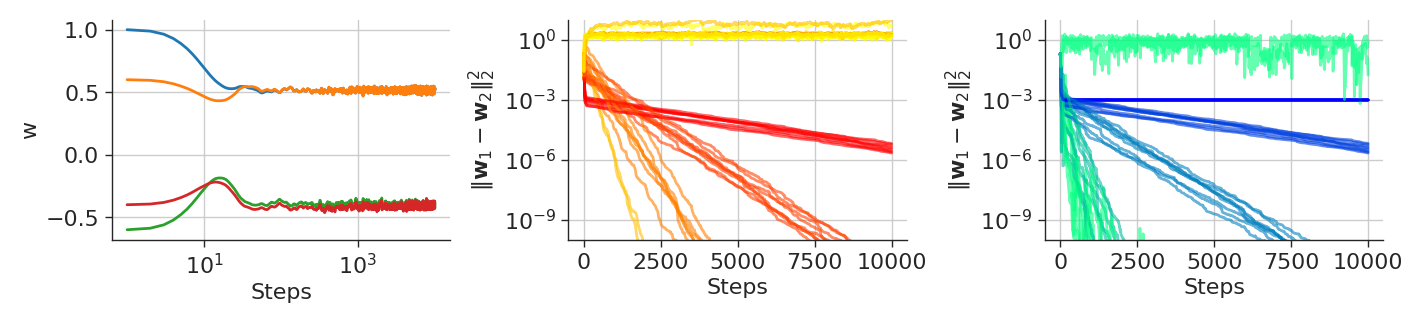

In [94]:
fig, axes = plt.subplots(1,3,figsize=(2.8*2.5, 0.6*2.5), width_ratios=[1, 1,1])

axes[0].plot(np.arange(1,10002),np.array(model_list_list_lr[0][0])[:,0,0],label=r'$w_1^{(1)}$')
axes[0].plot(np.arange(1,10002),np.array(model_list_list_lr[0][0])[:,0,1],label=r'$w_2^{(1)}$')
axes[0].plot(np.arange(1,10002),np.array(model_list_list_lr[0][0])[:,1,0],label=r'$w_1^{(2)}$')
axes[0].plot(np.arange(1,10002),np.array(model_list_list_lr[0][0])[:,1,1],label=r'$w_2^{(2)}$')
#axes[0].legend(fontsize=7,bbox_to_anchor=[-0.5,0.0], loc="upper left",ncol=4,handlelength=1)
#axes[0].xlim(1,10000)
axes[0].set_xscale('log')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('w')


cmap = matplotlib.cm.get_cmap('autumn', 5)
model_list_list=model_list_list_lr
for j in range(8):
    if j==7:
        for i in range(5):
            axes[1].plot((np.array(model_list_list[j][i])[:,0,0]-np.array(model_list_list[j][i])[:,0,1])**2+(np.array(model_list_list[j][i])[:,1,0]-np.array(model_list_list[j][i])[:,1,1])**2,color=cmap(i),alpha=.6,label='lr=%.1f'%[0.1,0.2,0.3,0.4,0.5][i])
    else:
        for i in range(5):
            axes[1].plot((np.array(model_list_list[j][i])[:,0,0]-np.array(model_list_list[j][i])[:,0,1])**2+(np.array(model_list_list[j][i])[:,1,0]-np.array(model_list_list[j][i])[:,1,1])**2,color=cmap(i),alpha=.6)  
axes[1].set_yscale('log')
axes[1].set_ylim(1e-10,1e1)
axes[1].set_yticks([1e-9,1e-6,1e-3,1e0])
axes[1].set_xlabel('Steps')
axes[1].set_ylabel(r'$\|\mathbf{w}_1-\mathbf{w}_2\|^2_2$')
#axes[1].legend(fontsize=7,bbox_to_anchor=[-0.5,0.0], loc="upper left",ncol=5,handlelength=1)

cmap = matplotlib.cm.get_cmap('winter', 5)
model_list_list=model_list_list_sigma
for j in range(8):
    if j==7:
        for i in range(5):
            axes[2].plot((np.array(model_list_list[j][i])[:,0,0]-np.array(model_list_list[j][i])[:,0,1])**2+(np.array(model_list_list[j][i])[:,1,0]-np.array(model_list_list[j][i])[:,1,1])**2,color=cmap(i),alpha=.6,label=r'$\sigma$='+'%.1f'%[0.0,0.1,0.2,0.4,0.8][i])
    else:
        for i in range(5):
            axes[2].plot((np.array(model_list_list[j][i])[:,0,0]-np.array(model_list_list[j][i])[:,0,1])**2+(np.array(model_list_list[j][i])[:,1,0]-np.array(model_list_list[j][i])[:,1,1])**2,color=cmap(i),alpha=.6)  
axes[2].set_yscale('log')
axes[2].set_xlabel('Steps')
axes[2].set_ylim(1e-10,1e1)
axes[2].set_yticks([1e-9,1e-6,1e-3,1e0])
axes[2].set_ylabel(r'$\|\mathbf{w}_1-\mathbf{w}_2\|^2_2$')

plt.savefig('Fig_3.0.pdf',bbox_inches='tight')